# Predict a wine's score based on its description
*Loïc Gauthier*

In this kernel, I'm taking a look at a great data set about wines from Zack Thoutt. It contains about 130k user reviews (description, score, price...) of wines from various origins.

My goal for this kernel is to predict the score a user will give to a wine, solely based on the description he redacted. To that end, I'll be following the following structure.

        O. Imports
        1. First Look
        2. Checking for missing values
        3. Descriptive statistics, distribution fitting and outliers
        4. Text Mining
            a) Defining features
            b) Dimension reduction
        5. Machine Learning
        6. Conclusion


## 0. Imports

In [1]:
#Easy data manipulation
import pandas as pd
import numpy as np

#Plotting
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
import matplotlib.pyplot as plt

#Who likes warnings anyway?
import warnings
warnings.filterwarnings('ignore')

#Pre-processing, tuning of parameters and scoring tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score, roc_curve

#Basic text mining tools
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text #Allow stop_words customization

#Machine Learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

#Used for distribution fitting, and representation
from scipy import stats

#Time measuring for model training
from time import time

We read the data set.

In [2]:
df = pd.read_csv('../input/winemag-data-130k-v2.csv')

## 1. First look

In [3]:
print("Number of entries (rows):", df.shape[0],\
      "\nNumber of features (columns):", df.shape[1])

df.head(3)

Number of entries (rows): 129971 
Number of features (columns): 14


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


For our study, we will only consider the following features:
* "description": contains a short description of a specific wine, its flavor and its aspect redacted by a user. This is the only explanatory variable we will use.
* "points": contains the score between 80/100 and 100/100 given to a wine by a user. This is the variable we want to predict based on the description.

Let's see if there are any missing values for these two features in the data set, and simply drop the line if there are. 

## 2. Checking for missing values

In [4]:
#Keep only the useful columns and rename them for ease of use
df = df[['description', 'points']]
df.rename(columns={'description':'Description',
                   'points':'Score'},
                   inplace=True)
 
#Add a column with the length of the description in characters, we use it to check for empty descriptions
df["Description_Length"] = [len(desc) for desc in df['Description']]

#Check for missing values
print("Number of missing values for the Score feature: ", len(df[df['Score'].isnull()]))
print("Number of missing descriptions: ", len(df[df['Description_Length']==0]))

Number of missing values for the Score feature:  0
Number of missing descriptions:  0


Perfect ! We have no missing scores or desciptions, so no entry to drop.

We will now keep the Description_Length feature to see if it is useful to help predict a wine's score. Let's take a look at the basic statistics of our 2 numerical features : Score and Description_Length. 

## 3. Descriptive statistics, distribution fitting and outliers

In [5]:
df.describe()

,Score,Description_Length
count,129971.000000,129971.000000
mean,88.447138,242.601065
std,3.039730,66.584276
min,80.000000,20.000000
25%,86.000000,197.000000
50%,88.000000,237.000000
75%,91.000000,282.000000
max,100.000000,829.000000


In a more visual way, we can see most of these descriptive statistics on the following plots.

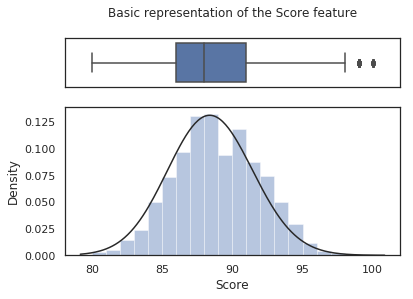

In [6]:
#Make a subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Associate a plot to each of the subplot grid
sns.boxplot(df["Score"], ax=ax_box).set_title("Basic representation of the Score feature\n")
sns.distplot(df["Score"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20) 
#We can fit a gamma distribution, just for the sake of representation.
 
#Set axes legends
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()


In [7]:
Q3 = np.quantile(df['Score'], 0.75) #Third quartile
Q1 = np.quantile(df['Score'], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df[ df['Score'] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df['Score'])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 52 
Outlier proportion: 0.04 % 
Outlier threshold score: 98.5 / 100


50% of the scores are between 86/100 and 91/100. There are only a few outliers , 52 (representing 0.04% of entries), which scored over 98.5/100.

An interpretation would be that excellent wines are rarer. Another could be that users reviewing wines are very hard to please.

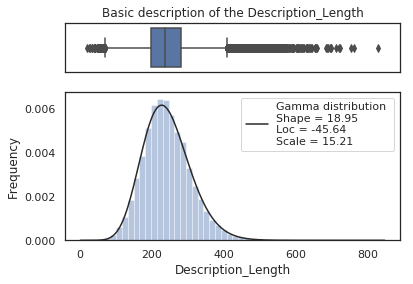

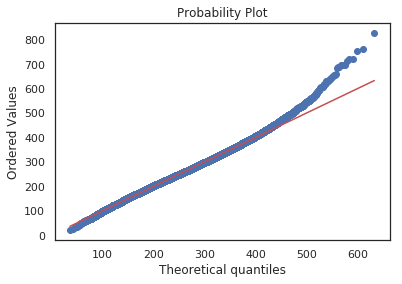

Skewness: 0.616101
Kurtosis: 1.205444


In [8]:
#Make a subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Associate a plot to each of the subplot grid
sns.boxplot(df["Description_Length"], ax=ax_box).set_title("Basic description of the Description_Length")
sns.distplot(df["Description_Length"], ax=ax_hist, kde=False, fit=stats.gamma, bins=50) 
#We can fit a gamma distribution, the fit is rather impressive here.

#Parameters of the gamma distribution
alpha, loc, beta = stats.gamma.fit(df['Description_Length'])
plt.legend(['Gamma distribution \nShape = {0:.2f} \nLoc = {1:.2f}  \nScale = {2:.2f}'.format(alpha, loc, beta)],loc='best')

#Set axes legends
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Frequency')

plt.show()

#How good is the fit with the gamma distribution ?
fig = plt.figure()
res = stats.probplot(df['Description_Length'], dist=stats.gamma(a= alpha, loc=loc, scale=beta), plot=plt)
plt.show()

#Other basic statistics
print("Skewness: %f" % df['Description_Length'].skew())
print("Kurtosis: %f" % df['Description_Length'].kurt())

Looking at the QQ-plot, we see that Description_Length seems to follow a Gamma distribution. The only deviation from the gamma distribution is the Description_Length of above 400 words. In other words, the actual underlying distribution of Description_Length has an heavier right tail than the gamma distribution we fitted.

Now, as we'll see in the following cell, these Description_Lengths of more than 400 words can mostly be considered as outliers.

In [9]:
Q3 = np.quantile(df['Description_Length'], 0.75) #Third quartile
Q1 = np.quantile(df['Description_Length'], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range

outlier_score_threshold_high = Q3 + 1.5 * IQR
outlier_score_threshold_low = Q1 - 1.5 * IQR

outlier_number_total=len(df[np.logical_or(df['Description_Length'] > outlier_score_threshold_high,
                         df['Description_Length'] < outlier_score_threshold_low)])

outlier_number_low = len(df[df['Description_Length'] < outlier_score_threshold_low])
outlier_number_high = outlier_number_total - outlier_number_low

print("Number of outliers (high - low):", outlier_number_total, "(",outlier_number_high,"-",outlier_number_low,")",
      "\nOutlier proportion:", round(outlier_number_total/len(df['Description_Length'])*100, 3),"%",
      "\nOutlier threshold lengths (high - low):", outlier_score_threshold_high,"-",outlier_score_threshold_low)

Number of outliers (high - low): 2090 ( 1969 - 121 ) 
Outlier proportion: 1.608 % 
Outlier threshold lengths (high - low): 409.5 - 69.5


The descriptions are between 20 and 829 words long. The IQR is rather small: 50% of the descriptions are between 197 and 282 words long. Here we have a few more outliers than for the Score feature: 1969 entries are made of more than 409 words and 121 are made of fewer than 69. To put it in perspective, outliers represent 1.6% of the data set.

This could indicate that users are serious about reviewing wine, and want to justify their evaluation extensively. 

We could also hyothesize that there is not a lot to be said about really bad wines, meaning that the 121 descriptions made of fewer than 69 words are only about bad wines. Let's verify that !

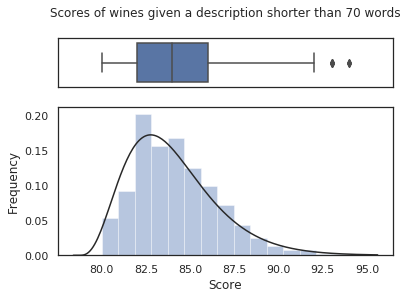

Mean score given after a description shorter than 70 words: 84.02 / 100
Proportion of wines with short description with a score below the set's median: 90.5 %


In [10]:
#These are the entries with a very short description
sub_df = df[df['Description_Length']<outlier_number_low]

#Make a subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Associate a plot to each of the subplot grid
sns.boxplot(sub_df['Score'], ax=ax_box).set_title("Scores of wines given a description shorter than 70 words\n")
sns.distplot(sub_df['Score'], ax=ax_hist, kde=False, fit=stats.gamma, bins=15) 
 
#Set axes legends
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Frequency')

plt.show()

mean_score = np.mean(sub_df['Score'])
print("Mean score given after a description shorter than 70 words:", round(mean_score,2), "/ 100")

proportion_below_median = len(sub_df[sub_df['Score']<88]['Score'])/len(sub_df['Score'])
print("Proportion of wines with short description with a score below the set's median:", round(proportion_below_median*100,2),"%")


This confirms that short descriptions tends to be about wines with lower scores. Indeed, more than 90% of the wines which were given a description with fewer than 70 words are scoring below the data set's average and median.

This also means that the Description_Length feature will definetly be useful in order to predict the scores.

Now, let's make a scatter plot of the Desciption_Length with respect to the Score.

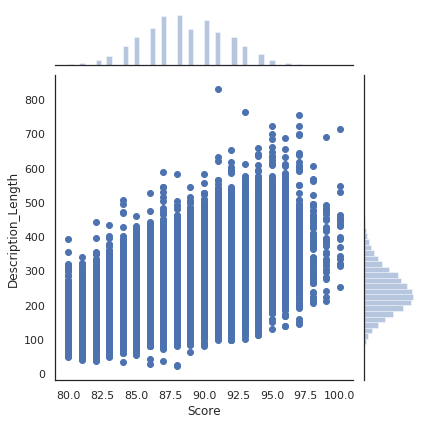

Correlation between Score and Description_Length: 0.56


In [11]:
sns.jointplot(x="Score", y="Description_Length", data=df)
plt.show()

corr= np.corrcoef(df["Score"], df["Description_Length"])[0,1]
print("Correlation between Score and Description_Length:",round(corr,2))

There is a positive, albeit weak correlation between Score and Description_Length. It doesn't seem wise to try to predict a wine's score solely based on its description length with a linear model though.

## 4. Text mining
### a) Defining features

We separate the descriptions and the scores. The Description_Length feature will be added later on.

In [12]:
corpus = df["Description"].values
Y = df["Score"].values

We use sklearn's CountVectorizer with some custom stop_words to build a sparse matrix of 1000 features (words).

In [13]:
#Customize stop words after having a first look at the most frequent words
customStopWords = text.ENGLISH_STOP_WORDS.union(['wine', '2009', '2010','2011', '2012', '2013', '2014', '2015','2016', '2017', '2018',
                                                 '2019', '2020', '2021', '2022','2023', '2024', '2025', '2030', '100', '10', '12',
                                                 '14', '15', '20', '25', '30','40', '50', '60', '70', '90'])
#The words we add to the english stop words are mostly references to dates and prices, hence numbers.

#Use the CountVectorizer: we consider 1000 features, either individual words or pairs
CV = CountVectorizer(stop_words=customStopWords, max_features=1000, ngram_range=(1,2))
X = CV.fit_transform(corpus) #Let's be careful here, X is a sparse Matrix

print("Number of entries (rows):", X.shape[0],\
      "\nNumber of features (columns):", X.shape[1])

Number of entries (rows): 129971 
Number of features (columns): 1000


Now, if we want to, we can take a look at the top 20 most frequent words / pair of words, we can. Although this is neither the most elegant, nor fastest way to do it, the following approach works just fine.

In [14]:
X_array = X.toarray() #Convert X from a sparse matrix to a usual matrix

inverted_dict = dict([[v,k] for k,v in CV.vocabulary_.items()]) # {X_array column index: "word"}
final_dict = {} # {"word": total number of instances }

for x in range(len(X_array[0,:])): #Fill the final dict
    final_dict[inverted_dict[x]]=np.sum(X_array[:,x]) 

print("20 most frequent words:",sorted(final_dict.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[0:20]) #Display of the final dict

20 most frequent words: [('flavors', 62796), ('fruit', 49939), ('aromas', 39639), ('palate', 38523), ('acidity', 35003), ('finish', 34974), ('tannins', 30878), ('drink', 30323), ('cherry', 29322), ('black', 29024), ('ripe', 27377), ('red', 21784), ('spice', 19233), ('notes', 19047), ('oak', 17769), ('fresh', 17527), ('rich', 17466), ('dry', 17222), ('berry', 16983), ('nose', 16963)]


We will now use TF-IDF. It it a classical method used to determine the importance of each word in the corpus.

Quoting Wikipedia: "The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Tf–idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf–idf."

*Note : instead of using CountVectorizer, and then TF-IDF, it would have been equivalent to use directly TfidfVectorizer.*

In [15]:
TFIDF = TfidfTransformer()
X_TFIDF = TFIDF.fit_transform(X)

### b) Dimension reduction
At that point, we have a (129971x1000) matrix describing the information contained in wines' descriptions. Having 1000 features might slow us down a lot when we'll use machine learning models on it.

Let's see the impact of TruncatedSVD, a dimension reduction technique similar to PCA but for sparse matrices, on the loss of explained variance. Is it worth it to give up some information for easier computation ?

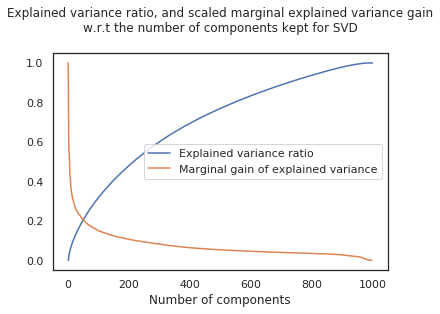

In [18]:
Y_rep = [0] #Will stock the cumulative explained variance ratio of the SVD, for each n_components

#Actual SVD
SVD = TruncatedSVD(n_components = 999) 
X_SVD = SVD.fit_transform(X_TFIDF)
var = SVD.explained_variance_ratio_

#This will help us decide on the final number of components we want to keep 
for x in range(999): 
    Y_rep.append(Y_rep[-1]+var[x])

plt.plot(Y_rep)
plt.plot(sorted(var*78, reverse=True))

plt.title("Explained variance ratio, and scaled marginal explained variance gain\nw.r.t the number of components kept for SVD\n")
plt.legend(['Explained variance ratio', 'Marginal gain of explained variance'], loc='best')
plt.xlabel('Number of components')
plt.ylabel('')

plt.show() 

At first, each additionnal component adds a lot to the explained variance ratio. With each additional component, the marginal gain of explained variance decreases steeply until around 50 components. After that, the marginal gain decreases a lot slower.

We will try to keep our 1000 components to learn from. If some models take too long, we might come back to dimension reduction and  Truncated SVD. But with no specific application in mind, it doesn't seem necessary to loose information to lower the training duration of some models.

## 5. Machine Learning

To make the problem more convenient to work with, we will make it a classification problem. Let's define 2 balanced classes. The first one (0) will be associated to wines scoring below the median score, and the second (1) above the median score.

In [19]:
#Balanced discretization in 2 classes
median = np.median(Y) #88.0
Y[Y < median] = 0
Y[Y >= median] = 1

#Re-type Y as int
Y=Y.astype(int)

#Concatenation of X_TFIDF and Description_Length to obtain our final X matrix
X = np.append(X_TFIDF.toarray(), df["Description_Length"].values[:, None], axis=1)

print("Number of entries:", X.shape[0],\
      "\nNumber of features:", X.shape[1])

Number of entries: 129971 
Number of features: 1001


As usual, in order to make sure our models evaluation doesn't reward overfitting, we divide our explanatory features and class label in a train set (70% of entries) and a test set (30% of entries).

We will train models on train sets, and then evaluate them on test sets.

In [20]:
#Test/Train split
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3, shuffle=True)

But before training, we have to normalize our data. Indeed, while TFIDF already kind of does that already for our 1000 first features, we need to normalize the Description_Length feature for better results with certain algorithms (like kNN for instance)

In [21]:
#Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)    #We don't cheat here, we fit our scaler only on the train data
X_test = scaler.transform(X_test)          #X_test is ONLY transformed, based on X_train fit

Our setup is completed, we can now try some models. For more convenience, we begin by defining a simple function for training and scoring models in order to help us choose the best.

In [22]:
def FitAndScore(classifier, X_train, X_test, y_train, y_test):
    print("Fitting...")
    start = time()
    classifier.fit(X_train, y_train)
    end = time()
    print("( {0:.2f} seconds )".format(end-start))
    
    print("\nPredicting...")
    start = time()
    y_predicted = classifier.predict(X_test)
    end = time()
    print("( {0:.2f} seconds )".format(end-start))
    
    print("\nReporting...\n")
    print(classification_report(y_test, y_predicted),"\n")
    print("Confusion matrix:\n")
    print(confusion_matrix(y_test, y_predicted),"\n")
    print("Cohen's Kappa score : ",cohen_kappa_score(y_test, y_predicted),"\n")
    
    #If we formulate the problem with binary classes, we can take a look at the ROC curve and associated score
    if len(np.unique(y_test)) == 2:
        print("AUC score : {0:.3f}".format(roc_auc_score(y_test, y_predicted)))
        fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(fpr, tpr, marker='.')
        plt.title("ROC Curve")
        plt.show()

Let's try a first simple model: a decision tree using Gini impurity as a criterion, and a max depth of 10.

Fitting...
( 27.06 seconds )

Predicting...
( 0.19 seconds )

Reporting...

              precision    recall  f1-score   support

           0       0.70      0.60      0.64     15548
           1       0.76      0.83      0.79     23444

   micro avg       0.74      0.74      0.74     38992
   macro avg       0.73      0.71      0.72     38992
weighted avg       0.73      0.74      0.73     38992
 

Confusion matrix:

[[ 9261  6287]
 [ 3975 19469]] 

Cohen's Kappa score :  0.4370301839777291 

AUC score : 0.713


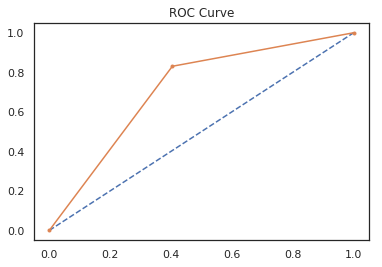

In [23]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10)
FitAndScore(dt, X_train, X_test, y_train, y_test)

This simple decision tree has been really fast to train, and gives already good results. It seems that our tree predicts above-median scoring wines with more ease.

Another rather simple classification algorithm would have been kNN. However, given the number of features, this approach would take too long. Instead, we can use a faster approach: a Naive Bayes classifier for multinomial models.

It's true that Naive Bayes classification is based on applying Bayes' theorem hypothesizing independence of the features. This condition is probably not fully fulfilled here, but let's try anyway.

Fitting...
( 0.59 seconds )

Predicting...
( 0.16 seconds )

Reporting...

              precision    recall  f1-score   support

           0       0.71      0.68      0.70     15548
           1       0.79      0.82      0.81     23444

   micro avg       0.76      0.76      0.76     38992
   macro avg       0.75      0.75      0.75     38992
weighted avg       0.76      0.76      0.76     38992
 

Confusion matrix:

[[10598  4950]
 [ 4252 19192]] 

Cohen's Kappa score :  0.5040735465092943 

AUC score : 0.750


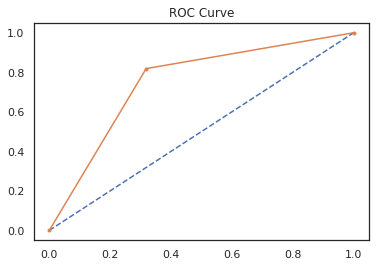

In [24]:
#We have negative values, so let's scale everyting between 0 and 1 to use naive bayes classifier
mmscaler = MinMaxScaler()
X_train_01 = mmscaler.fit_transform(X_train)    #Still no cheating with this scaling
X_test_01 = mmscaler.transform(X_test)          

nb = MultinomialNB()
FitAndScore(nb, X_train_01, X_test_01, y_train, y_test)

MultinomialNB was even faster than the simple decision tree classifier, and gives slightly better results. Here again, the model has more trouble predicting low scores (class 0) than high scores (class 1).

Let's try if we can get even better results by using SVM with simple linear kernel. If our entries are linearly separable, this should find a relevant hyperplane.

Fitting...
[LibLinear]( 82.31 seconds )

Predicting...
( 0.09 seconds )

Reporting...

              precision    recall  f1-score   support

           0       0.72      0.83      0.77     15548
           1       0.87      0.78      0.83     23444

   micro avg       0.80      0.80      0.80     38992
   macro avg       0.80      0.81      0.80     38992
weighted avg       0.81      0.80      0.80     38992
 

Confusion matrix:

[[12904  2644]
 [ 5091 18353]] 

Cohen's Kappa score :  0.5969683869442327 

AUC score : 0.806


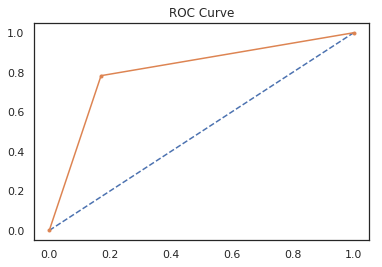

In [25]:
LSVC = LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                 intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                 multi_class='ovr', penalty='l2', tol=1e-05, verbose=2)

FitAndScore(LSVC, X_train, X_test, y_train, y_test)

The results given by SVM with simple linear kernel are even better. Although, it took twice as long as our decision tree classifier, and 100 times longer than the Naive Bayes approach. So depending on the application, the model choice is not necessarily obvious here.

Let's try to see if we can get even better result with a Random Forest Classifier with 100 estimators.

Fitting...
( 165.78 seconds )

Predicting...
( 3.19 seconds )

Reporting...

              precision    recall  f1-score   support

           0       0.81      0.73      0.77     15548
           1       0.83      0.89      0.86     23444

   micro avg       0.83      0.83      0.83     38992
   macro avg       0.82      0.81      0.81     38992
weighted avg       0.82      0.83      0.82     38992
 

Confusion matrix:

[[11308  4240]
 [ 2576 20868]] 

Cohen's Kappa score :  0.6287491258258697 

AUC score : 0.809


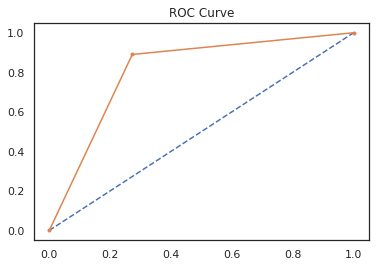

In [26]:
rf = RandomForestClassifier(n_estimators = 100, bootstrap=True, n_jobs=-1)
FitAndScore(rf, X_train, X_test, y_train, y_test)

The results keep getting better ! Sadly, the time needed for training is also mush higher. Here it is still reasonnable due to the relatively low number of trees generated.

For this model, let's take a look at the feature importances.

In [27]:
features = CV.vocabulary_
features['Description_Length']=1000

importances = rf.feature_importances_

features_inv = dict([[v,k] for k,v in features.items()]) #Structure {X index:'feature name'}
final_features_dict = {} #Structure {'feature name':relative importance}
for i in range(len(importances)):
    final_features_dict[features_inv[i]] = importances[i]

sorted_feature_importance = sorted(final_features_dict.items(), key = lambda kv:[kv[1], kv[0]], reverse=True)
sorted_feature_importance[0:20]

[('Description_Length', 0.0831917569403688),
 ('flavors', 0.020640564419405764),
 ('simple', 0.01732999836551781),
 ('aromas', 0.012064975216124848),
 ('rich', 0.011901941153140116),
 ('black', 0.008820285494075429),
 ('drink', 0.008505697709777472),
 ('finish', 0.008059641843831043),
 ('soft', 0.008052117596018512),
 ('years', 0.007757893242743348),
 ('ripe', 0.007604818355582405),
 ('acidity', 0.007451640175634121),
 ('long', 0.007288435284662756),
 ('sweet', 0.006950511119708911),
 ('fruit', 0.006915463522477283),
 ('light', 0.00684397139163068),
 ('palate', 0.006395198469940029),
 ('concentrated', 0.006283835117296858),
 ('fruity', 0.006078380640879249),
 ('easy', 0.006013384292289797)]

The most important feature is Description_Length by relatively far.

A popular way to increase the results of a Random Forest Classifier is to use Adaboosting. Quoting sklearn's documentation: "An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases."

The training of the model will be rather long as it will need to train multiple random forests. To keep that acceptable, we will only use 10 random forests of 100 trees. Better results might be achievable by increasing those numbers, but the training time would be just too long.

Fitting...
( 3209.18 seconds )

Predicting...
( 33.39 seconds )

Reporting...

              precision    recall  f1-score   support

           0       0.84      0.70      0.76     15548
           1       0.82      0.91      0.86     23444

   micro avg       0.82      0.82      0.82     38992
   macro avg       0.83      0.80      0.81     38992
weighted avg       0.83      0.82      0.82     38992
 

Confusion matrix:

[[10820  4728]
 [ 2119 21325]] 

Cohen's Kappa score :  0.623132463397531 

AUC score : 0.803


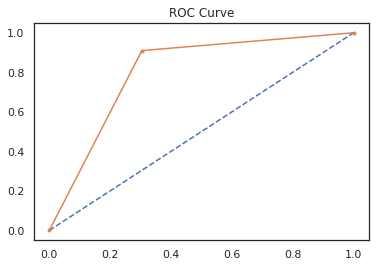

In [28]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1);
bclf = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
FitAndScore(bclf, X_train, X_test, y_train, y_test)

Surprisingly enough, the Adaboosted Random Forest shows worse results than the simple random forest. Although, it would probably get better with more estimators, but the training would also be much longer, so here again, it all depends on the application.

Our last machine learning model will be a simple neural network, a Multi-Layer Perceptron Classifier. Neural networks, when tuned correctly, have the potential to perform better than other models. The problem is that finding the right hyperparameters would require an entire dedicated kernel (or several), and the training time can take some time. So here, I'll just use the MLP classifier with mostly default parameters.

Fitting...
Iteration 1, loss = 0.48384536
Iteration 2, loss = 0.39732942
Iteration 3, loss = 0.39004297
Iteration 4, loss = 0.38772081
Iteration 5, loss = 0.38685643
Iteration 6, loss = 0.38569841
Iteration 7, loss = 0.38533636
Iteration 8, loss = 0.38445488
Iteration 9, loss = 0.38443889
Iteration 10, loss = 0.38407863
Iteration 11, loss = 0.38352819
Iteration 12, loss = 0.38323902
Iteration 13, loss = 0.38290065
Iteration 14, loss = 0.38234861
Iteration 15, loss = 0.38201774
Iteration 16, loss = 0.38157544
Iteration 17, loss = 0.38147271
Iteration 18, loss = 0.38055012
Iteration 19, loss = 0.38074692
Iteration 20, loss = 0.38008922
Iteration 21, loss = 0.37916041
Iteration 22, loss = 0.37841628
Iteration 23, loss = 0.37758585
Iteration 24, loss = 0.37683534
Iteration 25, loss = 0.37567234
Iteration 26, loss = 0.37441387
Iteration 27, loss = 0.37307085
Iteration 28, loss = 0.37182788
Iteration 29, loss = 0.37050217
Iteration 30, loss = 0.36914710
Iteration 31, loss = 0.36778966
Iterat

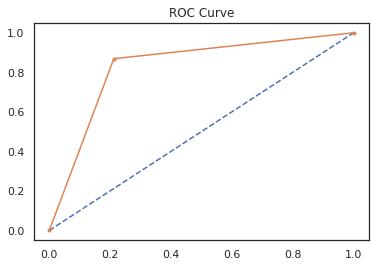

In [29]:
mlp = MLPClassifier(activation='logistic', alpha=1e-03, batch_size='auto',\
                    beta_1=0.9, beta_2=0.999, early_stopping=False,\
                    epsilon=1e-08, hidden_layer_sizes=(600,400),\
                    learning_rate='constant', learning_rate_init=0.0001,\
                    max_iter=200, momentum=0.9, n_iter_no_change=10,\
                    nesterovs_momentum=True, power_t=0.5,\
                    shuffle=True, solver='adam', tol=0.00001,\
                    validation_fraction=0.1, verbose=True, warm_start=False)

FitAndScore(mlp, X_train, X_test, y_train, y_test)

Our neural network gives slightly better results than other models. But its training took A LOT of time. It might or might not be worth it depending on the application.

Once again, it's highly probable that with better hyperparameters, we could get even better results.

## 6. Conclusion

In this kernel, we analyzed the Description and Score of wines from the dataset. We found out that the distribution of the number of words in a description is very close to a gamma distribution, except it has a bigger right tail. We also found that short descriptions are usually given to bad wines.

Then, using elementary text mining techniques, we transformed the wines descriptions into a matrix containing 1001 features. Thanks to machine learning algorithms, we used this matrix to predict the adequate score corresponding to the description.

The best performing model "out of the box" was a simple random forest with 100 estimators. The most important feature it used was the description length. Its training took around 3 minutes. Of course it's possible to get even better results by tuning the hyperparameters used with GridSearchCV, RandomizedSearchCV, or even a fully automatized approach like tpot.

Thanks a lot for taking the time to read this kernel !
